# MAS Final Homework Assignment
Daniel Engbert, Dec 2022

In [1]:
# helper function for use in code code below
import random
import numpy as np

def set_seed(seed=42):
  rng = random.Random()
  if seed is None:
    seed = random.randint(0, 9999)
  rng.seed(seed)
  np.random.seed(seed)

## Monte Carlo Estimation of Shapely Value

How to fairly split a taxi fare across $\{1, ... N\}$ players can be calculated using [Shapely values](https://en.wikipedia.org/wiki/Shapley_value), which treats this scenario as a cooperative game.
For this problem we assume that all players live on the way of the Nth player, and that player $A$ lives at distance of 1, player $B$ at a distance of 2, etc.

### Computing Shapely values for $n=4$:
The code below computes all permutations (a.k.a. "coalitions") of the $N=4$ players $\{A, B, C, D\}$, then for each permutation, `perm`, it assigns each player a share off the total payoff (the fare of total cost 4), by assuming player `perm[0]` showed up first at the taxi, followed by players `perm[1]`, `perm[2]`, `perm[3]`.

For example, for the permutation `perm = ['A', 'C', 'B', 'D']`, the respective payoffs (fare splits) will be `{'A': 1, 'B': 0, 'C': 2, 'D': 1}` (here player $B$ pays 0 because by the time he arrives at the taxi, it was already going to go by his house anyways due to player $C$.)

The final computed Shapely values are simply the average payoffs of each player across all possible permutations.


In [2]:
import random
import shapley

def get_player_vals(N: int):
    """
    Returns mapping of N player names (strings) to their distance along the taxi route.
    e.g. for N=4: {'A': 1, 'B': 2, 'C': 3', 'D': 4}
    """
    if N <= 26:
        return {chr(ord('A') + n): n+1 for n in range(0, N)}
    return {n+1: n+1 for n in range(0, N)}

def get_shapley(N: int):
    #player_vals = {'A': 6, 'B': 12, 'C': 42} # should result in shapely values {2, 5, 35}
    player_vals = get_player_vals(N)
    print(f"player_vals = {player_vals}")
    players = list(player_vals.keys())

    # list of permutations of coalitions of size len(players)
    perms = shapley.get_perms(players)
    print(f"there are {len(perms)} total permutations of {len(players)} players:")
    display(perms[:5]) # print first few rows
    print('(only the first 5 rows of permutations are shown above)')

    running_payoffs = {p: 0 for p in players}
    total_payoff = max(player_vals.values())
    for perm in perms:
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
        running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: v/len(perms) for (k,v) in running_payoffs.items()}
    print(f"\nshapley_values: (for N = {N})")
    print(shapely_values)

    #print('percent of payoff:')
    #print({k: v/total_payoff for (k,v) in shapely_values.items()})

get_shapley(4)


player_vals = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
there are 24 total permutations of 4 players:


[['A', 'B', 'C', 'D'],
 ['A', 'B', 'D', 'C'],
 ['A', 'C', 'B', 'D'],
 ['A', 'C', 'D', 'B'],
 ['A', 'D', 'B', 'C']]

(only the first 5 rows of permutations are shown above)

shapley_values: (for N = 4)
{'A': 0.25, 'B': 0.5833333333333334, 'C': 1.0833333333333333, 'D': 2.0833333333333335}


As can be seen from the output, the shapely values for $n=4$ players is `{'A': 0.25, 'B': 0.583, 'C': 1.083, 'D': 2.083}`

### Estimating Shapley values for $n=100$
Here we use [Monte Carlo sampling](https://en.wikipedia.org/wiki/Monte_Carlo_method) to approximiate the Shapely values for the taxi fare problem when $n=100$.


estimated shapley values: (for N = 50 players, and 100000 of permutations):
{1: 0.0205, 2: 0.04127, 3: 0.05944, 4: 0.08532, 5: 0.10297, 6: 0.12639, 7: 0.14951, 8: 0.17658, 9: 0.19715, 10: 0.21036, 11: 0.23762, 12: 0.2684, 13: 0.30175, 14: 0.33172, 15: 0.35215, 16: 0.37486, 17: 0.41329, 18: 0.4459, 19: 0.46783, 20: 0.51971, 21: 0.51456, 22: 0.55716, 23: 0.61947, 24: 0.62232, 25: 0.70721, 26: 0.7125, 27: 0.76579, 28: 0.80693, 29: 0.84677, 30: 0.92257, 31: 0.93308, 32: 0.99514, 33: 1.06003, 34: 1.11974, 35: 1.1868, 36: 1.22937, 37: 1.31052, 38: 1.41043, 39: 1.51232, 40: 1.52945, 41: 1.67506, 42: 1.78823, 43: 1.93268, 44: 2.0864, 45: 2.24827, 46: 2.38358, 47: 2.63949, 48: 2.97551, 49: 3.52112, 50: 4.50478}

sum of estimated shapley values: 50.0


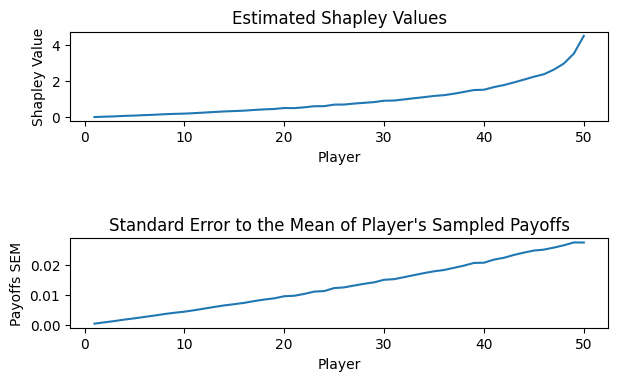

In [6]:
import matplotlib.pyplot as plt
import scipy

def estimate_shapley(N: int, samples: int):
    player_vals = get_player_vals(N)

    players = list(player_vals.keys())
    players_set = set(players)

    # store list of sampled payoffs for each player
    running_payoffs = {p: [] for p in players}
    total_payoff = max(player_vals.values())
    for _ in range(samples):
        perm = shapley.get_random_perm(players_set)
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
            running_payoffs[p].append(cur[p])
        #running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: sum(pays)/samples for (k,pays) in running_payoffs.items()}
    print(f"\nestimated shapley values: (for N = {N} players, and {samples} of permutations):")
    print(shapely_values)
    print(f"\nsum of estimated shapley values: {sum(shapely_values.values())}")

    fig, axs = plt.subplots(2)
    fig.tight_layout(pad=6.0)
    fig.set_size_inches(8, 5)
    axs[0].set_title(f"Estimated Shapley Values")
    axs[0].set_xlabel(f'Player')
    axs[0].set_ylabel(f"Shapley Value")
    axs[0].plot(players, [shapely_values[p] for p in players])

    axs[1].set_title(f"Standard Error to the Mean of Player's Sampled Payoffs")
    axs[1].set_xlabel(f'Player')
    axs[1].set_ylabel(f"Payoffs SEM")
    sems = [scipy.stats.sem(pays) for player, pays in running_payoffs.items()]
    axs[1].plot(player_vals.keys(), sems)



estimate_shapley(50, 100000)

---
## Monte Carlo Tree Search (MCTS)

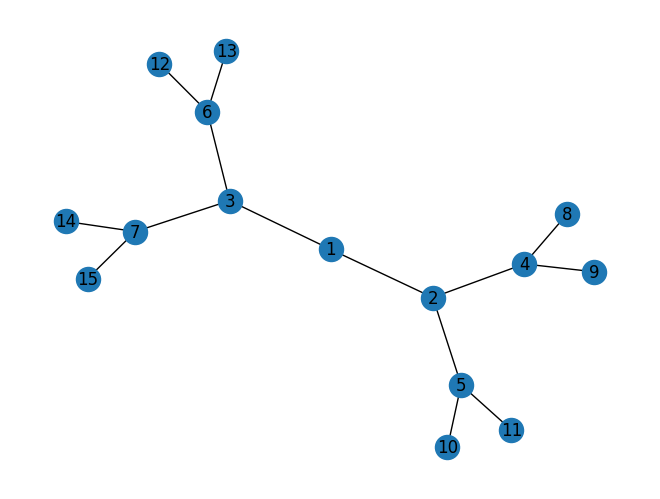

target node = #15, num leaf nodes = 8, max distance: 3, min distance: 0


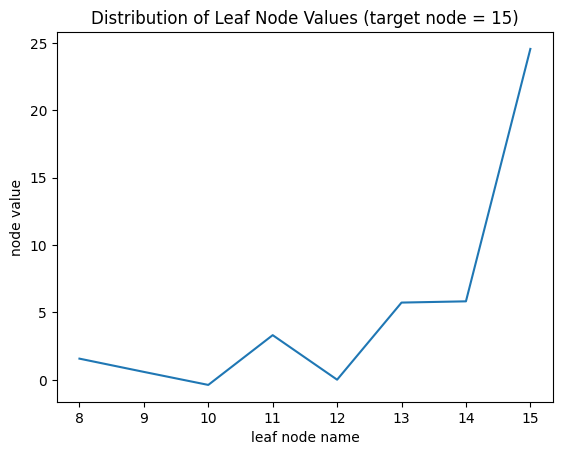

In [9]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import importlib
import tree_search as ts
importlib.reload(ts)

MCTS = ts.MCTS

###### experiment params
set_seed(None)
#depth = 10
depth = 4   # depth of tree to search
B = 25      # for computing values of leaf nodes
c = 2       # hyperparam
# TODO: define computational budget
######

#tree = ts.create_tree(depth, draw=True)
mc = MCTS(depth, c=c, B=B, draw=True)
#nx.draw(tree, with_labels=True, node_size=300)



# now do MCTS:
# store in each node:
# {'values': []} # (also tells you num visits)


---
## RL: SARSA and Q-Learning

In [5]:
import numpy as np

EMPTY = 0
WALL = 1
SNAKES = 2
TREASURE = 3

def create_world():
  world = np.zeros((9,9), dtype=int)
  world[1, 2:7] = WALL
  world[1:5, 6] = WALL
  world[7, 1:5] = WALL
  world[6:5] = SNAKES
  world[-1, -1] = TREASURE
  return world

world = create_world()
display(world)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3]])